In [1]:
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install xgboost
!pip install imbalanced-learn

  Using cached imbalanced_learn-0.14.1-py3-none-any.whl.metadata (8.9 kB)
  Using cached sklearn_compat-0.1.5-py3-none-any.whl.metadata (20 kB)
Using cached imbalanced_learn-0.14.1-py3-none-any.whl (235 kB)
Using cached sklearn_compat-0.1.5-py3-none-any.whl (20 kB)

   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   -------------------- ------------------- 1/2 [imbalanced-learn]
   ---------------------------------------- 2/2 [imbalanced-learn]



STARTING DIABETES CLASSIFICATION PIPELINE

Data shape: (768, 9)
Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

Train shape: (614, 9), Test shape: (154, 9)
Train shape after SMOTE: (800, 9), (800,)
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}

Test Metrics:
  ACCURACY: 0.7468
  PRECISION: 0.6230
  RECALL: 0.7037
  F1: 0.6609
  ROC_AUC: 0.8144
  PR_AUC: 0.6920

Artifacts saved successfully.

PIPELINE COMPLETED SUCCESSFULLY!



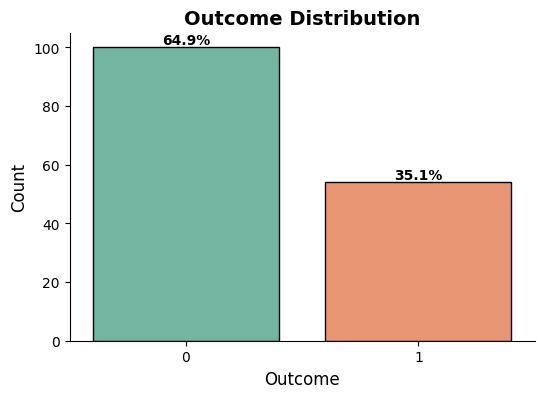

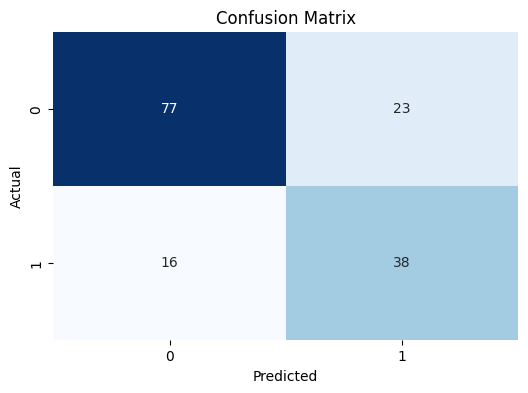

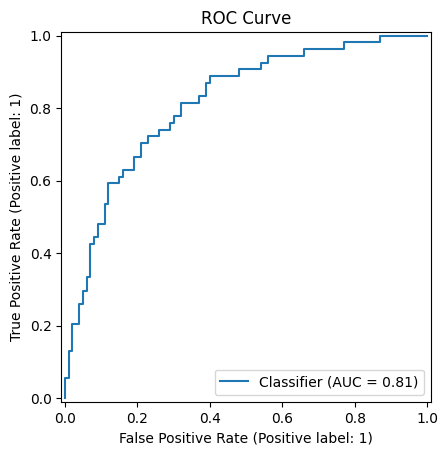

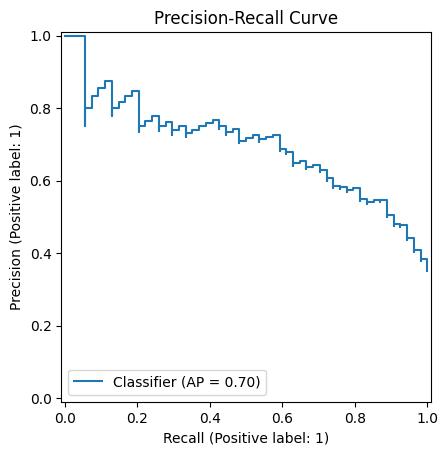

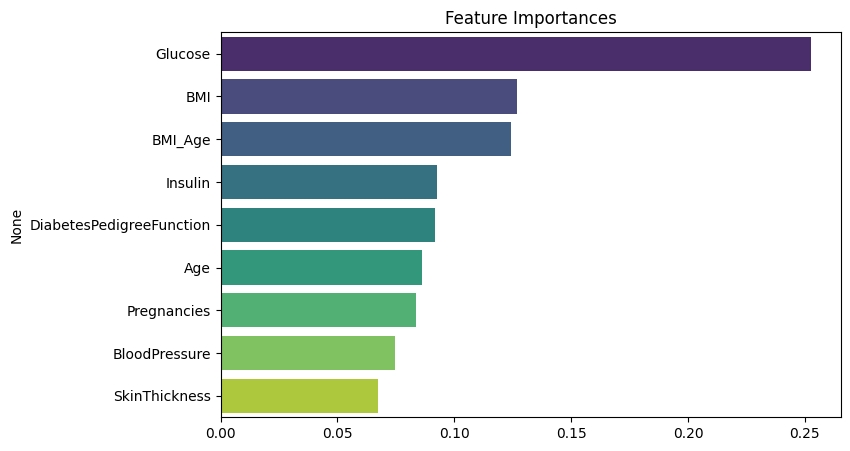

In [3]:
# ===================== Diabetes Prediction Pipeline =====================
import pandas as pd
import numpy as np
import joblib
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, RocCurveDisplay, precision_recall_curve, auc
)
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

# ===================== CONFIGURATION =====================
class Config:
    DATA_PATH = 'diabetes.csv'
    TARGET_COL = 'Outcome'
    TEST_SIZE = 0.2
    RANDOM_STATE = 42

    MODEL_TYPE = 'XGBoost'  # Options: LogisticRegression / RandomForest / XGBoost
    USE_GRID_SEARCH = True

    # Paths for saving
    MODEL_SAVE_PATH = 'models/best_model.pkl'
    PREPROCESSOR_SAVE_PATH = 'models/scaler.pkl'
    METRICS_SAVE_PATH = 'models/metrics.json'

                              # ===================== PIPELINE FUNCTION =====================
def run_diabetes_pipeline(config: Config):
    print('='*60)
    print('STARTING DIABETES CLASSIFICATION PIPELINE')
    print('='*60)

    # ----------- 1. Load Data ----------
    df = pd.read_csv(config.DATA_PATH)
    print(f'\nData shape: {df.shape}')
    print(f'Columns: {list(df.columns)}')

    # --------- 2. Handle invalid zeros ---------
    cols_with_invalid_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
    df[cols_with_invalid_zero] = df[cols_with_invalid_zero].replace(0, np.nan)

    # -------- 3. Features & Target --------
    X = df.drop(columns=[config.TARGET_COL])
    y = df[config.TARGET_COL]

    # Optional: Feature Engineering (can add more)
    X['BMI_Age'] = X['BMI'] * X['Age']  

    # ---------- 4. Train-Test Split -----------
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=config.TEST_SIZE, random_state=config.RANDOM_STATE, stratify=y
    )
    print(f'\nTrain shape: {X_train.shape}, Test shape: {X_test.shape}')

    # -------- 5. Preprocessing ---------
    numeric_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    X_train_scaled = numeric_pipeline.fit_transform(X_train)
    X_test_scaled = numeric_pipeline.transform(X_test)

    # ------- 5b. Handle class imbalance with SMOTE -------
    sm = SMOTE(random_state=config.RANDOM_STATE)
    X_train_scaled, y_train = sm.fit_resample(X_train_scaled, y_train)
    print(f'Train shape after SMOTE: {X_train_scaled.shape}, {y_train.shape}')

    # ----------- 6. Select Model ---------
    if config.MODEL_TYPE == 'LogisticRegression':
        model = LogisticRegression(random_state=config.RANDOM_STATE, max_iter=1000)
        param_grid = {'C': [0.01, 0.1, 1, 10]}
    elif config.MODEL_TYPE == 'RandomForest':
        model = RandomForestClassifier(random_state=config.RANDOM_STATE, n_jobs=-1)
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7]
        }
    elif config.MODEL_TYPE == 'XGBoost':
        model = XGBClassifier(random_state=config.RANDOM_STATE, use_label_encoder=False, eval_metric='logloss', n_jobs=-1)
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.3]
        }
    else:
        raise ValueError(f'Model "{config.MODEL_TYPE}" not supported')

    # ----------- 7. Train Model ----------
    if config.USE_GRID_SEARCH:
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=config.RANDOM_STATE)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_
        print(f'\nBest parameters: {grid_search.best_params_}')
    else:
        model.fit(X_train_scaled, y_train)
        best_model = model

    # ---------- 8. Evaluate Model ------
    y_prob = best_model.predict_proba(X_test_scaled)[:,1]

    # Threshold tuning for better recall
    threshold = 0.4  # Lower than 0.5 to catch more positives
    y_pred = (y_prob >= threshold).astype(int)

    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob)
    }

    # PR-AUC
    precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall_vals, precision_vals)
    metrics['pr_auc'] = pr_auc

    print('\nTest Metrics:')
    for k, v in metrics.items():
        print(f'  {k.upper()}: {v:.4f}')

    # ---------------- 9. Save Artifacts ----------------
    Path('models').mkdir(exist_ok=True)
    joblib.dump(best_model, config.MODEL_SAVE_PATH)
    joblib.dump(numeric_pipeline, config.PREPROCESSOR_SAVE_PATH)
    with open(config.METRICS_SAVE_PATH, 'w') as f:
        json.dump(metrics, f, indent=2)
    print('\nArtifacts saved successfully.')

    print('\nPIPELINE COMPLETED SUCCESSFULLY!\n')

    return {
        'model': best_model,
        'scaler': numeric_pipeline,
        'X_test': X_test_scaled,
        'y_test': y_test,
        'y_pred': y_pred,
        'y_prob': y_prob,
        'metrics': metrics,
        'feature_names': X.columns.tolist()
    }

# ===================== VISUALIZATION FUNCTION =====================
def plot_results(result):
    X_test, y_test, y_pred, y_prob = result['X_test'], result['y_test'], result['y_pred'], result['y_prob']

    # 1. Outcome Distribution
    plt.figure(figsize=(6,4))
    total = len(y_test)
    sns.countplot(x=y_test, palette='Set2', edgecolor='black')
    for p in plt.gca().patches:
        count = p.get_height()
        pct = f'{100*count/total:.1f}%'
        plt.gca().annotate(pct, (p.get_x() + p.get_width()/2, count), ha='center', va='bottom', fontsize=10, fontweight='bold')
    plt.title('Outcome Distribution', fontsize=14, fontweight='bold')
    plt.xlabel('Outcome', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    sns.despine()
    plt.show()

    # 2. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # 3. ROC Curve
    RocCurveDisplay.from_predictions(y_test, y_prob)
    plt.title('ROC Curve')
    plt.show()

    # 4. Precision-Recall Curve
    from sklearn.metrics import PrecisionRecallDisplay
    PrecisionRecallDisplay.from_predictions(y_test, y_prob)
    plt.title('Precision-Recall Curve')
    plt.show()

    # 5. Feature Importance (tree-based models)
    if hasattr(result['model'], 'feature_importances_'):
        importances = result['model'].feature_importances_
        feat_imp = pd.Series(importances, index=result['feature_names']).sort_values(ascending=False)
        plt.figure(figsize=(8,5))
        sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')
        plt.title('Feature Importances')
        plt.show()

# ===================== MAIN =====================
if __name__ == '__main__':
    result = run_diabetes_pipeline(Config)
    plot_results(result)